In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

*Only run next cell if you want to generate the data from the logs again*

In [44]:
# Get all the trace files
files = glob.glob("../src/benchmarks/*/logs/arg_trace.log")

benchmark_names = [f.split("/")[3] for f in files]

df = pd.DataFrame()
for file in files:
    benchmark_name = file.split("/")[3]
    print(benchmark_name)
    f = open(file, "r")
    file_data = {"call_id": [], "ts": [], "op": [], "args": []}
    # read every line and split it by spaces
    counter = 0
    for line in f:
        if line == '\n': continue
        splitted_line = line.split(" ")
        # First element is in between []
        file_data["ts"].append(splitted_line[0][1:-1])
        # Remove from second element everything that comes after the parenthesis
        file_data["op"].append(splitted_line[1].split("(")[0])

        # For now, put the rest in the arg
        # If parenthesis in the string, add everything that is after the first
        # parenthesis
        if "(" in line:
            file_data["args"].append(line[line.find('('):].strip())
        elif len(splitted_line) > 2:
            file_data["args"].append(" ".join(splitted_line[2:]).strip())
        else:
            raise Exception("Parsing error: ", line)
        
        file_data["call_id"].append(counter)
        counter += 1
        

    file_df = pd.DataFrame(file_data)
    # Multi level indexing, first level is the benchmark name

    file_df["benchmark"] = benchmark_name
    df = pd.concat([df, file_df])

df.set_index(["benchmark", "call_id"], inplace=True)
df.to_pickle("traces.pkl")

latency
hotspot
bfs
yolop
dwt2d
gaussian
myocyte
resnext101
midas
vgg19
resnet50-py
alexnet
resnext50
srad_v1
pathfinder


In [2]:
df = pd.read_pickle("traces.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50525 entries, ('latency', 0) to ('pathfinder', 20)
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ts      50525 non-null  object
 1   op      50525 non-null  object
 2   args    50525 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [3]:
# Quickly look at most used operations
df["op"].value_counts()

cudaMemcpy                                     15845
Synchronization                                 8656
cudaLaunchKernel                                7550
cudaMemcpyAsync                                 2499
cudaStreamSynchronize                           2498
cudaThreadSynchronize                           2049
cudnnCreateTensorDescriptor                     1326
cudnnDestroyTensorDescriptor                    1326
cudnnSetTensorNdDescriptor                      1326
cudnnSetConvolutionMathType                      732
cudnnSetStream                                   663
cublasLtMatmulDescSetAttribute                   436
cudnnCreateFilterDescriptor                      366
cudnnSetFilterNdDescriptor                       366
cudnnCreateConvolutionDescriptor                 366
cudnnSetConvolutionNdDescriptor                  366
cudnnSetConvolutionGroupCount                    366
cudnnDestroyConvolutionDescriptor                366
cudnnDestroyFilterDescriptor                  

In [4]:
# Look at the benchmark with the most synchronous calls
df.loc[df["op"] == "Synchronization"].groupby("benchmark").count().sort_values("op", ascending=False)['op']

benchmark
myocyte        7808
yolop           368
srad_v1         225
midas           115
resnext101       51
resnet50-py      44
vgg19            25
alexnet          13
pathfinder        7
Name: op, dtype: int64

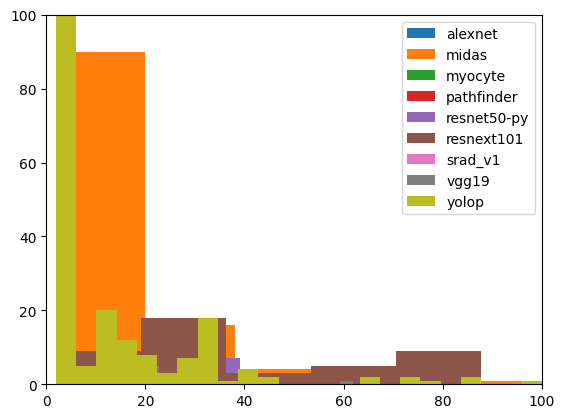

In [171]:
# Look at the distribution of the distance between synchronous calls in the benchmarks
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]
for group in dist.groupby("benchmark"):
    group_name = group[0]
    plt.hist(group[1], bins=100, label=group_name)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()

# for benchmark in dist.index.levels[0]:
    # dist.loc[benchmark].plot.hist(bins=100, alpha=0.5, label=benchmark)

In [181]:
# Number of consecutive diff in synchronous calls
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]

"Percentage of same consecutive in between synch calls lenght", (dist.diff() == 0).sum() / len(dist)

('Percentage of same consecutive in between synch calls lenght',
 0.03469411356539841)

In [12]:
df

ts               op  \
benchmark  call_id                                         
latency    0        23:31:55:398:398487       cudaMalloc   
           1        23:31:56:617:617045       cudaMemcpy   
           2        23:31:56:617:617084       cudaMemcpy   
hotspot    0        23:30:44:926:926885       cudaMalloc   
           1        23:30:46:112:112985       cudaMalloc   
...                                 ...              ...   
pathfinder 16       12:32:53:078:078479         cudaFree   
           17       12:32:53:078:078710  Synchronization   
           18       12:32:53:078:078720         cudaFree   
           19       12:32:53:078:078733  Synchronization   
           20       12:32:53:078:078737         cudaFree   

                                                                 args  
benchmark  call_id                                                     
latency    0                                        (D0 (0), 4 bytes)  
           1        (cudaMemcpyHostToDevice) D1(0x7f2645600000) <-...  
           2        (cudaMemcpyDeviceToHost, H0(0x7ffeaf8d3554) <-...  
hotspot    0                                   (D0 (0), 100000 bytes)  
           1                                   (D0 (0), 100000 bytes)  
...                                                               ...  
pathfinder 16                             ( devPtr:{0x7ffa32000000} )  
           17                                                      5.  
           18                             ( devPtr:{0x7ffa37600000} )  
           19                                                      6.  
           20                             ( devPtr:{0x7ffa37661c00} )  

[50525 rows x 3 columns]

In [61]:
# Look if they are repetitive patterns with the synch calls as a starting point
unique_operations = df["op"].unique()
op_to_id_map = {op: value for value, op in zip(range(len(unique_operations)), unique_operations)}
df = df.assign(op_id=lambda x: x["op"].map(op_to_id_map))

# Insert nan for sequence
df["sequence"] = np.nan

for benchmark in df.index.levels[0]:
    print(benchmark)
    benchmark_df = df.loc[benchmark]
    pattern_data = {'call_id': [], 'sequence': []}
    sequence = []
    for idx, row in benchmark_df.iterrows():
        if row["op"] == "Synchronization":
            pattern_data['call_id'].append(idx)
            pattern_data['sequence'].append(sequence)
            sequence = []
        else:
            sequence.append(row["op_id"])

    df.loc[(benchmark, pattern_data['call_id']), 'sequence'] = pattern_data['sequence']

alexnet
bfs
dwt2d
gaussian


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

hotspot
latency
midas


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


myocyte


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

pathfinder
resnet50-py


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


resnext101


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


resnext50
srad_v1


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

vgg19
yolop


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [72]:
# count the amount of similar sequences in each benchmark
for benchmark in df.index.levels[0]:
    print(benchmark)
    print(df.loc[benchmark, 'sequence'].value_counts())

alexnet
[0, 6, 7, 6, 7]                                                                                                                                                                                                                                                                                     2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                   2
[]                                                                                                            

### Estimating how many times optimistic evaluation would be a thing...

In [125]:
df_sequence = df.dropna(subset=['sequence'])
# One has to reset the index to remove benchmarks with no sequences
df_sequence.reset_index(inplace=True)
df_sequence.set_index(['benchmark', 'call_id'], inplace=True)
df_sequence.index.levels[0].unique()

Index(['alexnet', 'midas', 'myocyte', 'pathfinder', 'resnet50-py',
       'resnext101', 'srad_v1', 'vgg19', 'yolop'],
      dtype='object', name='benchmark')

In [164]:
data_1 = {'benchmark': [], 'sequence': [], 'count': []}
data_2 = {'benchmark': [], 'sequence': [], 'count': []}
data_3 = {'benchmark': [], 'sequence': [], 'count': []}
for benchmark in df_sequence.index.levels[0]:
    print(benchmark)
    sequence_1 = None
    sequence_2 = None
    sequence_3 = None
    count_1 = 0
    count_2 = 0
    count_3 = 0

    for sequence in df_sequence.loc[benchmark, 'sequence']:
        if sequence == sequence_1:
            count_1 += 1
        elif count_1 > 0:
            data_1['benchmark'].append(benchmark)
            data_1['sequence'].append(sequence_1)
            data_1['count'].append(count_1)
            # print(sequence, count)
            count_1 = 0
        if sequence == sequence_2:
            count_2 += 1
        elif count_2 > 0:
            data_2['benchmark'].append(benchmark)
            data_2['sequence'].append(sequence_2)
            data_2['count'].append(count_2)
            # print(sequence, count)
            count_2 = 0
        if sequence == sequence_3:
            count_3 += 1
        elif count_3 > 0:
            data_3['benchmark'].append(benchmark)
            data_3['sequence'].append(sequence_3)
            data_3['count'].append(count_3)
            # print(sequence, count)
            count_3 = 0

        sequence_3 = sequence_2
        sequence_2 = sequence_1
        sequence_1 = sequence

df_1 = pd.DataFrame(data_1)
df_1['pattern'] = 1
df_2 = pd.DataFrame(data_2)
df_2['pattern'] = 2
df_3 = pd.DataFrame(data_3)
df_3['pattern'] = 3
optimistic_df = pd.concat([df_1, df_2, df_3])
optimistic_df.set_index(['benchmark', 'pattern'], inplace=True)

alexnet
midas
myocyte
pathfinder
resnet50-py
resnext101
srad_v1
vgg19
yolop


In [173]:
# Percentage among all synch calls that would benefit from being optimistically executed
print("Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence")
for i in range(1,4):
    print(i, ":", optimistic_df.xs(i, level=1)['count'].sum() / df.loc[df["op"] == "Synchronization"].shape[0]*100, "%")



Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence
1 : 2.114140480591497 %
2 : 94.29297597042515 %
3 : 2.634011090573013 %


In [175]:
optimistic_df.loc['myocyte']

,sequence,count
pattern,,
1,[0],2
1,[1],1
2,[0],1
2,"[1, 1, 1, 2]",7797
3,"[1, 1, 1, 2]",1


In [207]:
# Percentage among all synch calls that would benefit from being optimistically executed for each benchmark
synch_tot = df.loc[df["op"] == "Synchronization"].groupby("benchmark").count()
print(synch_tot.loc['alexnet']['op'])
for benchmark in optimistic_df.index.levels[0]:
    print(benchmark)
    for i in optimistic_df.index.levels[1]:
        try:
            print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")
        except KeyError: 
            pass # This happens when they are not such patterns in the benchmark

13
alexnet
1 : 23.076923076923077 %
midas
1 : 1.7391304347826086 %
2 : 5.217391304347826 %
3 : 59.130434782608695 %
myocyte
1 : 0.038422131147540985 %
2 : 99.8719262295082 %
3 : 0.012807377049180328 %
resnet50-py
1 : 20.454545454545457 %
2 : 9.090909090909092 %
3 : 18.181818181818183 %
resnext101
1 : 17.647058823529413 %
2 : 5.88235294117647 %
3 : 5.88235294117647 %
srad_v1
1 : 3.5555555555555554 %
2 : 90.66666666666666 %
3 : 1.7777777777777777 %
vgg19


/tmp/ipykernel_17080/59046860.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")


1 : 20.0 %
2 : 20.0 %
3 : 4.0 %
yolop
1 : 39.130434782608695 %
2 : 38.58695652173913 %
3 : 38.858695652173914 %
